# Calculate relationship between AP and dendritic spikes with poisson excitation with different E/I lags

The simulations had either: 
1. Poisson inhibition at the soma and dendrites, lagged at different delays w/r to the excitation 
2. Poisson excitation at the soma and dendrites

Here we calculate the spike-triggered average between dendritic spikes and action potentials. These are stratified by:
1. electrotonic distance of the dendritic segment from the soma
2. whether the dendritic branch was apical or basal
3. type of dendritic spike

The output of this script are a collection of NPY files, one for each simulation condition, dendrite type, and dendritic spike type, containing a numpy array with 3 dimensions:
1. the dendritic segment electrotonic quantile
2. time from the action potential

In [1]:
import os
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.sta_files import sta_files
from src.load_caspks_csv import load_caspks_csv
from src.load_spike_h5 import load_spike_h5
from src.cc_serser import cc_serser
from src.count_dendevt_files import count_dendevt_files

# Analysis parameters


In [2]:
samps_per_ms = 10 
sim_win = [0, 1500000] # beginning and start points of simulation in samples
sta_win = [-100, 100] # multiply by step to get window in milliseconds
sta_step = 1 # binning step for each point in the STA
step = 2 * samps_per_ms # number of simulation steps for creating the dendritic 
                        # event occurrence series

#### List files to be processed

In [3]:
# locate simulation files
root_dir = 'Y:\\DendCompOsc\\'
sim_dict = [{'SimName': 'prox500_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_500_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox250_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_250_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox125_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_125_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox50_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_50_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox10_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_10_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_500',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_500',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_250',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_250',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_125',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_125',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_50',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_50',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_10',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_10',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'proxn50_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_n50_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'proxn10_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_n10_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'proxn500_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_n500_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_n500',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_n500',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_n50',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_n50',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_n10',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_n10',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'},
            {'SimName': 'prox4_dist_4',
            'RootDir': root_dir,
            'SimDir': 'output_EI_prox_4_dist_4',
            'CaFileSuffix': '_ca.csv',
            'NaFileSuffix': '_na.csv',
            'NMDAFileSuffix': '_nmda.csv',
            'APFile': 'spikes.h5'}]

sim_df = pd.DataFrame(sim_dict)
sim_df.set_index('SimName', inplace=True)
sim_df



,RootDir,SimDir,CaFileSuffix,NaFileSuffix,NMDAFileSuffix,APFile
SimName,,,,,,
prox500_dist_4,Y:\DendCompOsc\,output_EI_prox_500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox250_dist_4,Y:\DendCompOsc\,output_EI_prox_250_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox125_dist_4,Y:\DendCompOsc\,output_EI_prox_125_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox50_dist_4,Y:\DendCompOsc\,output_EI_prox_50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox10_dist_4,Y:\DendCompOsc\,output_EI_prox_10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_4,Y:\DendCompOsc\,output_EI_prox_4_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_500,Y:\DendCompOsc\,output_EI_prox_4_dist_500,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_250,Y:\DendCompOsc\,output_EI_prox_4_dist_250,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_125,Y:\DendCompOsc\,output_EI_prox_4_dist_125,_ca.csv,_na.csv,_nmda.csv,spikes.h5


#### Generate STAs for dendritic spikes

In [4]:
# process the simulations
lag_sta = []

for sim_name, sim_dict in sim_df.iterrows():
    print(sim_name)
    sim_dir = os.path.join(sim_dict['RootDir'], sim_dict['SimDir'])
    ca_path = os.path.join(sim_dir, sim_dict['SimDir'] + sim_dict['CaFileSuffix'])
    na_path = os.path.join(sim_dir, sim_dict['SimDir'] + sim_dict['NaFileSuffix'])
    nmda_path = os.path.join(sim_dir, sim_dict['SimDir'] + sim_dict['NMDAFileSuffix'])
    ap_path = os.path.join(sim_dir, sim_dict['APFile'])
    proc_temp = {'sim_name': sim_name}
    proc_temp['ca_sta'] = sta_files(ca_path, ap_path, step, sim_win,
                                    sta_step,sta_win, agg_colname='Elec_distanceQ')
    proc_temp['nmda_sta'] = sta_files(nmda_path, ap_path, step, sim_win,
                                      sta_step,sta_win, agg_colname='Elec_distanceQ')
    proc_temp['na_sta'] = sta_files(na_path, ap_path, step, sim_win,
                                    sta_step,sta_win, agg_colname='Elec_distanceQ')
    lag_sta.append(proc_temp)



prox500_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox250_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox125_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox50_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox10_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox4_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox4_dist_500


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


prox4_dist_250


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


prox4_dist_125


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox4_dist_50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox4_dist_10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

proxn50_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

proxn10_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

proxn500_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox4_dist_n500


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


prox4_dist_n50


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


prox4_dist_n10


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

prox4_dist_4


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.cond

#### Plot percent change in dendritic event occurrence with repect to APs

In [5]:
t_list = np.arange(sta_win[0], sta_win[1], sta_step) * (step / samps_per_ms)
eqt_list = np.arange(9,-1,-1)

t_inds = np.where(np.abs(t_list)<=50)[0]
eqt_inds = np.arange(0,10)#np.where(eqt_list>0)[0]

def plot_sta_im(data_arr,ax,**kwargs):

    # Plot the data array as an image
    ax_im = ax.imshow(data_arr[eqt_inds[0]:eqt_inds[-2],t_inds[0]:t_inds[-1]], 
                      extent=[t_list[t_inds[0]], t_list[t_inds[-1]],
                              eqt_list[eqt_inds[0]], eqt_list[eqt_inds[-2]]],
                      interpolation='none',
                      cmap='coolwarm',
                      norm=colors.CenteredNorm(vcenter=0), 
                      **kwargs)
    
    # Plot the color bar
    plt.colorbar(ax_im,ax=ax)
    
    # Plot the vertical axis
    ax.axvline(0,color='white',linestyle=':')
    
    # Set the aspect ratio of the plot
    ax.set_aspect('auto')

def plot_sta_stair(data_arr,ax):
    mean_data = np.mean(data_arr[eqt_inds[0]:eqt_inds[-1],t_inds[0]:t_inds[-1]],0)

    ax_im = ax.stairs(mean_data, np.hstack((t_list[t_inds[:-1]], t_list[t_inds[-1]])),
                     fill=True, baseline=0)
    
    ax.axvline(0,color='black',linestyle=':')
    ax.set_aspect('auto')

In [6]:
def mean_sta(data_arr):
    return np.mean(data_arr[eqt_inds[0]:eqt_inds[-1],t_inds[0]:t_inds[-1]],0)

In [92]:
lag_sta[0]['ca_sta'].loc['apic'].sta

array([[ 12.33757309,  13.35420271,  10.30431384, ...,   9.58451453,
          6.91758753,   8.38893048],
       [ 15.57033055,  12.85492935,  12.61211463, ...,   1.37757425,
          2.57180961,   2.14903815],
       [  9.35147361,   8.91803158,   8.07450083, ...,   9.84620093,
          8.68482204,   7.00489694],
       ...,
       [ 89.80376508,  79.66179722,  79.66179722, ...,  10.19812896,
        -17.35140328, -31.1261694 ],
       [105.55049585,  97.7066034 ,  89.59763934, ...,  12.71161606,
        -27.29852969, -29.55523996],
       [105.01580485,  86.82928287,  68.14635459, ...,  30.78049801,
        -22.77515213, -22.77515213]])

In [7]:
def plot_sta_means(data, sim_list, sta_type, dend_sec, ax):
    for sim_name in sim_list:
        # find index of data where sim_name field matches sim_name
        sim_ind = [i for i, curr in enumerate(data) if curr['sim_name']==sim_name][0]
        mean_data = mean_sta(data[sim_ind][sta_type].loc[dend_sec].sta)

        # extract largest number from string sim_name
        max_num = max(map(int, re.findall(r'\d+', sim_name)))
        ax.plot(t_list[t_inds[:-1]], mean_data, label=max_num)
    ax.axvline(0,color='black',linestyle=':')
    ax.legend()
    ax.set_aspect('auto')

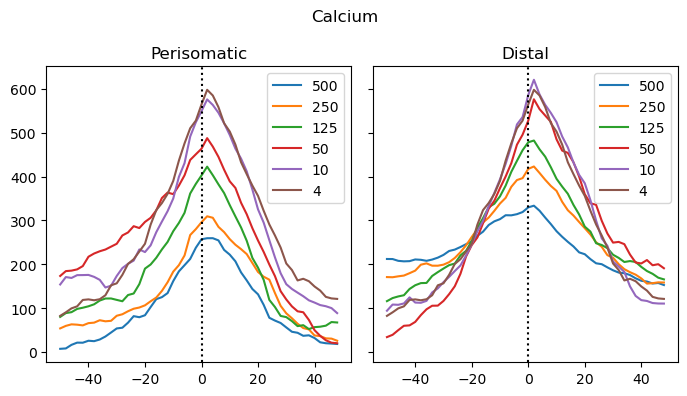

In [10]:

fig, ax = plt.subplots(1,2,figsize=(7,4), sharey=True)
plot_sta_means(lag_sta, ['prox500_dist_4','prox250_dist_4','prox125_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'ca_sta', 'apic', ax[0])
ax[0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_250','prox4_dist_125','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'ca_sta', 'apic', ax[1])
ax[1].set_title('Distal')
fig.suptitle('Calcium')
fig.tight_layout()

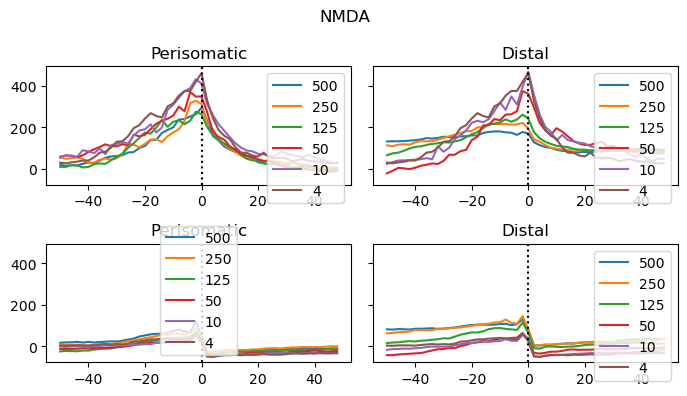

In [11]:
fig, ax = plt.subplots(2,2,figsize=(7,4), sharey=True)
plot_sta_means(lag_sta, ['prox500_dist_4','prox250_dist_4','prox125_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'nmda_sta', 'apic', ax[0,0])
ax[0,0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_250','prox4_dist_125','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'nmda_sta', 'apic', ax[0,1])
ax[0,1].set_title('Distal')
plot_sta_means(lag_sta, ['prox500_dist_4','prox250_dist_4','prox125_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'nmda_sta', 'dend', ax[1,0])
ax[1,0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_250','prox4_dist_125','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'nmda_sta', 'dend', ax[1,1])
ax[1,1].set_title('Distal')
fig.suptitle('NMDA')
fig.tight_layout()

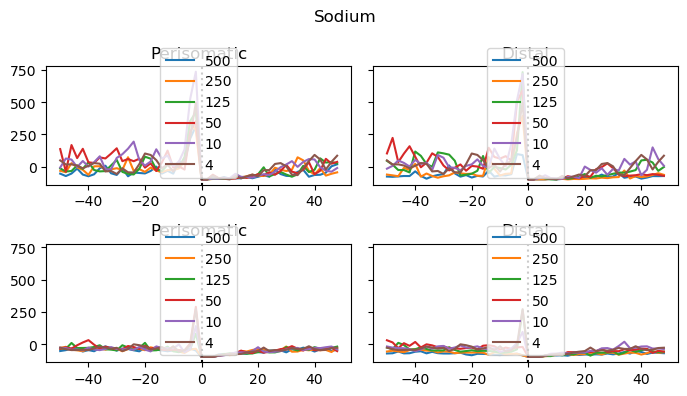

In [12]:
fig, ax = plt.subplots(2,2,figsize=(7,4), sharey=True)
plot_sta_means(lag_sta, ['prox500_dist_4','prox250_dist_4','prox125_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'na_sta', 'apic', ax[0,0])
ax[0,0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_250','prox4_dist_125','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'na_sta', 'apic', ax[0,1])
ax[0,1].set_title('Distal')
plot_sta_means(lag_sta, ['prox500_dist_4','prox250_dist_4','prox125_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'na_sta', 'dend', ax[1,0])
ax[1,0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_250','prox4_dist_125','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'na_sta', 'dend', ax[1,1])
ax[1,1].set_title('Distal')
fig.suptitle('Sodium')
fig.tight_layout()

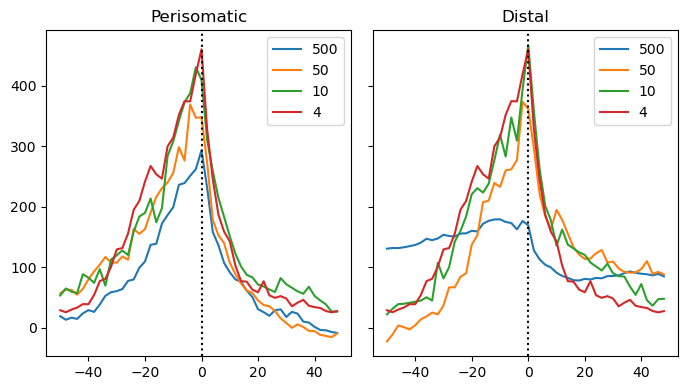

In [111]:
fig, ax = plt.subplots(1,2,figsize=(7,4), sharey=True)
plot_sta_means(lag_sta, ['prox500_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'nmda_sta', 'apic', ax[0])
ax[0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'nmda_sta', 'apic', ax[1])
ax[1].set_title('Distal')
fig.tight_layout()

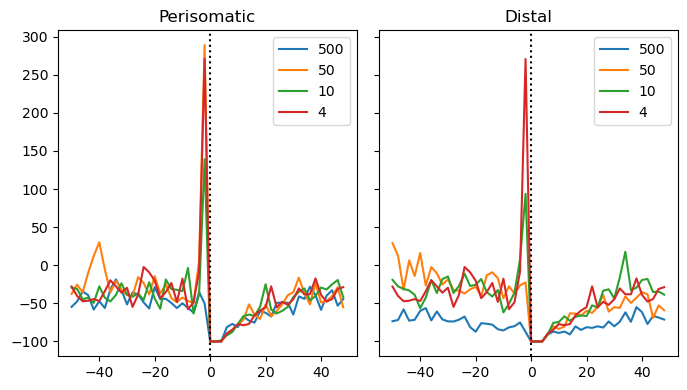

In [115]:
fig, ax = plt.subplots(1,2,figsize=(7,4), sharey=True)
plot_sta_means(lag_sta, ['prox500_dist_4','prox50_dist_4','prox10_dist_4', 'prox4_dist_4'],
               'na_sta', 'dend', ax[0])
ax[0].set_title('Perisomatic')
plot_sta_means(lag_sta, ['prox4_dist_500','prox4_dist_50','prox4_dist_10', 'prox4_dist_4'],
               'na_sta', 'dend', ax[1])
ax[1].set_title('Distal')
fig.tight_layout()

In [24]:
# Plot the STA across Na and NMDA events for each simulation
def plot_sta_sim(sta_dict):
    fig,ax = plt.subplots(2,2)
    plot_sta_im(sta_dict['nmda_sta'].loc['apic','sta'], ax[0,0])
    ax[0,0].set_title('NMDA Apical')
    plot_sta_im(sta_dict['nmda_sta'].loc['dend','sta'], ax[1,0])
    ax[1,0].set_title('NMDA Basal')
    plot_sta_im(sta_dict['na_sta'].loc['apic','sta'], ax[0,1])
    ax[0,1].set_title('Na Apical')
    plot_sta_im(sta_dict['na_sta'].loc['dend','sta'], ax[1,1])
    ax[1,1].set_title('Na Basal')
    fig.supxlabel('Time from action potential (ms)')
    fig.supylabel('Electrotonic quantile 90->0')
    fig.suptitle('Coordination of dendritic events and action potentials in ' + sta_dict['sim_name'])
    fig.tight_layout()

def plot_sta_sim_ca(sta_dict):
    fig,ax = plt.subplots()
    plot_sta_im(sta_dict['ca_sta'].loc['apic','sta'], ax)
    ax.set_title('Ca Apical')
    fig.supxlabel('Time from action potential (ms)')
    fig.supylabel('Electrotonic quantile 90->0')
    fig.suptitle('Coordination of dendritic events and action potentials in ' + sta_dict['sim_name'])
    fig.tight_layout()

def plot_sta_sim_stair(sta_dict):
    fig,ax = plt.subplots(2,2)
    plot_sta_stair(sta_dict['nmda_sta'].loc['apic','sta'], ax[0,0])
    ax[0,0].set_title('NMDA Apical')
    plot_sta_stair(sta_dict['nmda_sta'].loc['dend','sta'], ax[1,0])
    ax[1,0].set_title('NMDA Basal')
    plot_sta_stair(sta_dict['na_sta'].loc['apic','sta'], ax[0,1])
    ax[0,1].set_title('Na Apical')
    plot_sta_stair(sta_dict['na_sta'].loc['dend','sta'], ax[1,1])
    ax[1,1].set_title('Na Basal')
    fig.supxlabel('Time from action potential (ms)')
    fig.supylabel('Electrotonic quantile 90->0')
    fig.suptitle('Coordination of dendritic events and action potentials in ' + sta_dict['sim_name'])
    fig.tight_layout()

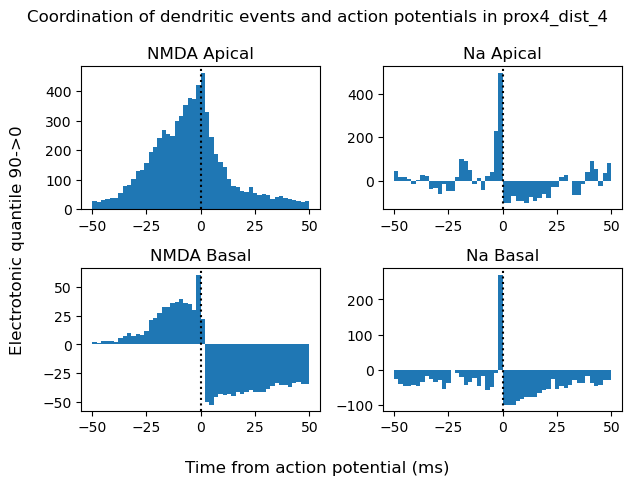

In [75]:
plot_sta_sim_stair(lag_sta[12])

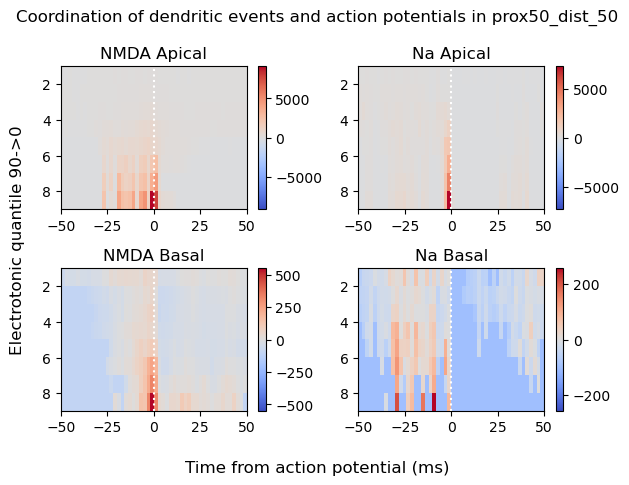

In [18]:
plot_sta_sim(lag_sta[1])

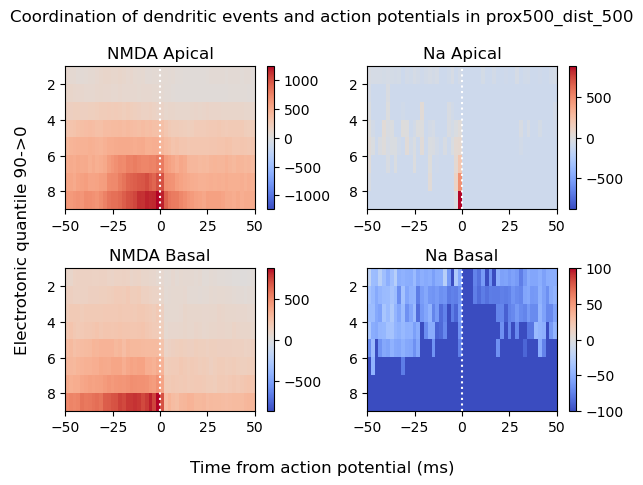

In [19]:
plot_sta_sim(lag_sta[2])

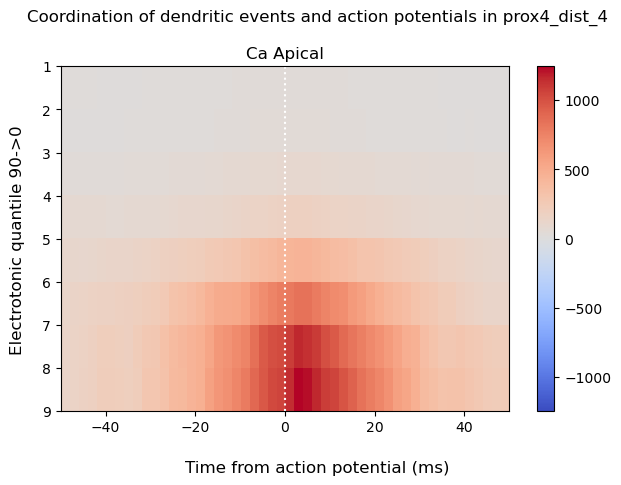

In [61]:
plot_sta_sim_ca(lag_sta[12])

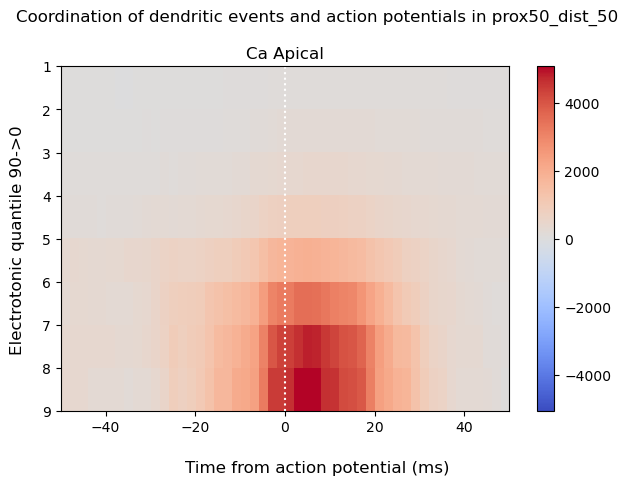

In [47]:
plot_sta_sim_ca(lag_sta[1])

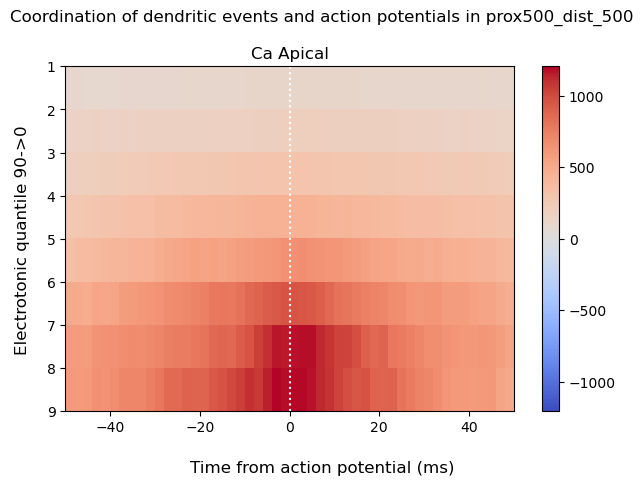

In [48]:
plot_sta_sim_ca(lag_sta[2])

NameError: name 'pois_sta' is not defined

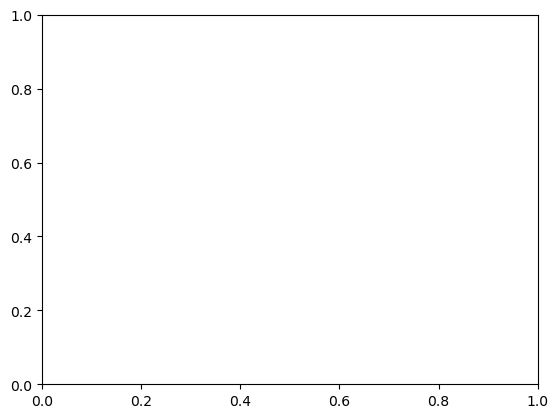

In [13]:
fig,ax = plt.subplots()
plot_sta_stair(pois_sta['ca_a'],ax)
ax.set_title('Ca Apical')
fig.supxlabel('Time from action potential (ms)')
fig.supylabel('Percent change')
fig.suptitle('Coordination of dendritic events and action potentials')
fig.tight_layout()
fig.savefig('../figures/CaSpikesCC.pdf')

#### Changes in firing rates across lags

In [62]:
sim_df

,RootDir,SimDir,CaFileSuffix,NaFileSuffix,NMDAFileSuffix,APFile
SimName,,,,,,
prox500_dist_4,Y:\DendCompOsc\,output_EI_prox_500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox50_dist_4,Y:\DendCompOsc\,output_EI_prox_50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox10_dist_4,Y:\DendCompOsc\,output_EI_prox_10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
proxn50_dist_4,Y:\DendCompOsc\,output_EI_prox_n50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
proxn10_dist_4,Y:\DendCompOsc\,output_EI_prox_n10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
proxn500_dist_4,Y:\DendCompOsc\,output_EI_prox_n500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_500,Y:\DendCompOsc\,output_EI_prox_4_dist_500,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_50,Y:\DendCompOsc\,output_EI_prox_4_dist_50,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_10,Y:\DendCompOsc\,output_EI_prox_4_dist_10,_ca.csv,_na.csv,_nmda.csv,spikes.h5


In [63]:
spk_dict = {}
for sim_name, sim_dict in sim_df.iterrows():
    print(sim_name)
    spk_dict[sim_name] = [load_spike_h5(os.path.join(sim_dict['RootDir'], sim_dict['SimDir'], sim_dict['APFile']))]

# convert spk_dict to a dataframe where each row is a different key/value pair
spk_df = pd.DataFrame.from_dict(spk_dict, orient='index', columns=['spk_times'])

spk_df['spk_rate'] = spk_df['spk_times'].apply(lambda x: len(x) / ((sim_win[1] - sim_win[0]) / (1000 * samps_per_ms)))
spk_df['spk_max'] = spk_df['spk_times'].apply(lambda x: max(x))
spk_df

prox500_dist_4
prox50_dist_4
prox10_dist_4
proxn50_dist_4
proxn10_dist_4
proxn500_dist_4
prox4_dist_500
prox4_dist_50
prox4_dist_10
prox4_dist_n500
prox4_dist_n50
prox4_dist_n10
prox4_dist_4


,spk_times,spk_rate,spk_max
prox500_dist_4,"[2269, 2337, 23917, 26440, 31481, 32097, 44954...",2.160000,1491366
prox50_dist_4,"[39, 9905, 10188, 10252, 10342, 10402, 21572, ...",2.833333,1488558
prox10_dist_4,"[41, 2319, 4039, 19305, 21571, 21716, 22038, 2...",3.220000,1488331
proxn50_dist_4,"[31, 21576, 25368, 26287, 27809, 39278, 39718,...",2.860000,1499225
proxn10_dist_4,"[38, 4524, 4749, 4837, 12926, 21552, 21735, 26...",3.093333,1499221
proxn500_dist_4,"[46, 19240, 21365, 21419, 21609, 21676, 21745,...",1.926667,1499430
prox4_dist_500,"[4062, 8726, 9089, 9278, 13822, 13882, 14285, ...",3.166667,1492946
prox4_dist_50,"[4468, 4586, 8518, 21957, 29326, 40531, 40645,...",2.606667,1486551
prox4_dist_10,"[30, 4059, 10602, 19358, 21529, 21616, 26802, ...",2.966667,1489701
prox4_dist_n500,"[36, 16424, 18526, 21443, 21574, 21705, 22366,...",3.233333,1499690


#### Rate of dendritic spike events across E/I lags

In [64]:
sim_df

,RootDir,SimDir,CaFileSuffix,NaFileSuffix,NMDAFileSuffix,APFile
SimName,,,,,,
prox500_dist_4,Y:\DendCompOsc\,output_EI_prox_500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox50_dist_4,Y:\DendCompOsc\,output_EI_prox_50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox10_dist_4,Y:\DendCompOsc\,output_EI_prox_10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
proxn50_dist_4,Y:\DendCompOsc\,output_EI_prox_n50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
proxn10_dist_4,Y:\DendCompOsc\,output_EI_prox_n10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
proxn500_dist_4,Y:\DendCompOsc\,output_EI_prox_n500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_500,Y:\DendCompOsc\,output_EI_prox_4_dist_500,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_50,Y:\DendCompOsc\,output_EI_prox_4_dist_50,_ca.csv,_na.csv,_nmda.csv,spikes.h5
prox4_dist_10,Y:\DendCompOsc\,output_EI_prox_4_dist_10,_ca.csv,_na.csv,_nmda.csv,spikes.h5


In [44]:
dend_df = sim_df.copy()
dend_df['dend_rate'] = dend_df.apply(lambda row: count_dendevt_files(
    os.path.join(row['RootDir'], row['SimDir'], row['SimDir'] + row['NMDAFileSuffix']), 
    0.001/float(samps_per_ms), sim_win),axis=1)



c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (18) 

In [32]:
dend_df.iloc[0]['dend_rate']

rate
Type Elec_distanceQ          
apic 0               5.491723
     1               2.512658
     2               2.630515
     3               3.758063
     4               2.768098
     5               1.836441
     6               1.059910
     7               0.657539
     8               0.500090
     9               0.423506
dend 0               7.875146
     1               9.961176
     2               7.837190
     3               5.091634
     4               4.155359
     5               2.537386
     6               1.590261
     7               0.851155
     8               0.223137
     9               0.017778

(array([ 35.,  23.,  33.,  38.,  31.,  30.,  21.,  20.,  20.,  18.,  18.,
         22.,  18.,  25.,  23.,  18.,  24.,  32.,  31.,  38.,  53.,  44.,
         58.,  43.,  54.,  47.,  46.,  50.,  57.,  40.,  62.,  56.,  45.,
         35.,  55.,  44.,  48.,  47.,  47.,  58.,  56.,  68.,  65.,  49.,
         63.,  72.,  77.,  91.,  76.,  84.,  79.,  68.,  66.,  49.,  44.,
         44.,  55.,  35.,  35.,  32.,  36.,  49.,  41.,  32.,  44.,  31.,
         31.,  44.,  20.,  17.,  25.,  20.,  19.,  29.,  25.,  38.,  33.,
         49.,  37.,  36.,  53.,  50.,  38.,  45.,  53.,  55.,  73.,  60.,
         86., 102.,  95., 123., 119., 121., 117., 133., 104., 118., 113.,
        132., 117., 124., 119.,  99.,  98.,  99.,  89.,  81.,  81.,  67.,
         63.,  81.,  61.,  79.,  76.,  82.,  73.,  84.,  57.,  73.,  65.,
         50.,  45.,  41.,  36.,  44.,  18.,  21.,  40.,  36.,  18.,  29.,
         21.,  41.,  40.,  21.,  48.,  25.,  37.,  41.,  22.,  41.,  44.,
         41.,  60.,  53.,  36.,  63., 

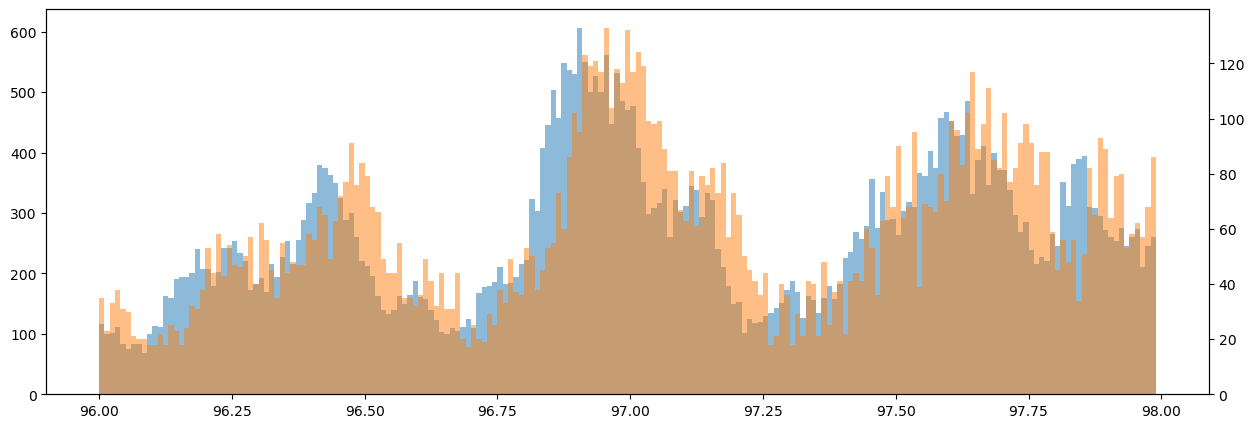

In [89]:
new_spks = h5py.File("C:\\Users\\dbh60\\Downloads\\exc_stim_spikes2.h5",'r')
#new_spks['spikes']['exc_stim'].keys()

spk_times = np.array(new_spks['spikes']['exc_stim']['timestamps']).astype(float)/1000

inh_spikes = h5py.File("C:\\Users\\dbh60\\Downloads\\dist_inh_stim_spikes2.h5",'r')
inh_spikes = np.array(inh_spikes['spikes']['dist_inh_stim']['timestamps']).astype(float)/1000

bin_t = np.arange(1,3,0.01) + 95
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(spk_times, bins=bin_t,alpha=0.5)
ax_t = ax.twinx()
ax_t.hist(inh_spikes+0.05, bins=bin_t, color='tab:orange', alpha=0.5)


In [34]:
dend_df

,RootDir,SimDir,CaFileSuffix,NaFileSuffix,NMDAFileSuffix,APFile,dend_rate
SimName,,,,,,,
prox500_dist_4,Y:\DendCompOsc\,output_EI_prox_500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
prox50_dist_4,Y:\DendCompOsc\,output_EI_prox_50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
prox10_dist_4,Y:\DendCompOsc\,output_EI_prox_10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
proxn50_dist_4,Y:\DendCompOsc\,output_EI_prox_n50_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
proxn10_dist_4,Y:\DendCompOsc\,output_EI_prox_n10_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
proxn500_dist_4,Y:\DendCompOsc\,output_EI_prox_n500_dist_4,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
prox4_dist_500,Y:\DendCompOsc\,output_EI_prox_4_dist_500,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
prox4_dist_50,Y:\DendCompOsc\,output_EI_prox_4_dist_50,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...
prox4_dist_10,Y:\DendCompOsc\,output_EI_prox_4_dist_10,_ca.csv,_na.csv,_nmda.csv,spikes.h5,rate Type Elec_distan...


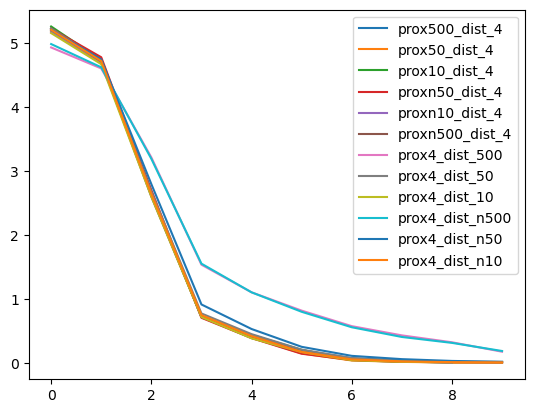

In [46]:
dend_type = 'apic'
fig, ax = plt.subplots()
for sim_name, dend_dict in dend_df.iterrows():
    curr_df = dend_dict['dend_rate'].loc[dend_type]
    ax.plot(curr_df.index.values, curr_df.values, label=sim_name)
ax.legend()

#### Examine inhibitory and excitatory afferents

'rate'

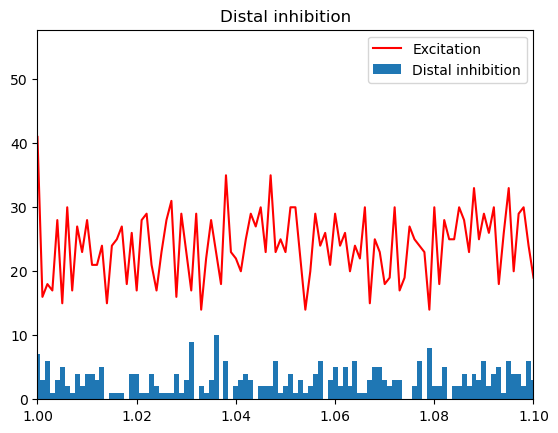

In [26]:
inh_prox_f = h5py.File("Y:\\DendCompOsc\\output_EI_prox_10_dist_4\\prox_inh_stim_spikes.h5", 'r')
inh_prox_t = np.array(inh_prox_f['spikes']['prox_inh_stim']['timestamps'])/(1000)

inh_dist_f = h5py.File("Y:\\DendCompOsc\\output_EI_prox_10_dist_4\\dist_inh_stim_spikes.h5", 'r')
inh_dist_t = np.array(inh_dist_f['spikes']['dist_inh_stim']['timestamps'])/(1000)

ex_f = h5py.File("Y:\\DendCompOsc\\output_EI_prox_10_dist_4\\exc_stim_spikes.h5", 'r')
ex_t = np.array(ex_f['spikes']['exc_stim']['timestamps'])/(1000)

# bin spikes
start_win = 1 #sim_win[0]/10000
end_win = 10.1 # sim_win[1]/10000
t_bins = np.linspace(start_win, end_win, int((end_win-start_win)*1000))
inh_prox_bin = np.histogram(inh_prox_t, t_bins)
inh_dist_bin = np.histogram(inh_dist_t, t_bins)
ex_bin = np.histogram(ex_t, t_bins)
 
fig, ax = plt.subplots()
ax.bar(inh_dist_bin[1][0:-1], inh_dist_bin[0], width = 0.001, label = 'Distal inhibition')
ax.plot(ex_bin[1][0:-1], ex_bin[0], color = 'red', label = 'Excitation')
ax.title.set_text('Distal inhibition')
ax.set_xlim([1, 1.1])
ax.legend()

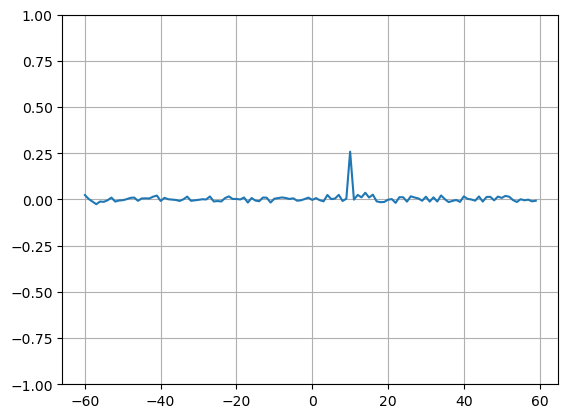

In [29]:
cc = cc_serser(inh_prox_bin[0].astype(float), ex_bin[0].astype(float), win=[-60, 60])
acinh = cc_serser(inh_dist_bin[0].astype(float), inh_dist_bin[0].astype(float), win=[-60, 60])
acex = cc_serser(ex_bin[0].astype(float), ex_bin[0].astype(float), win=[-60, 60])

# plot cc
fig, ax = plt.subplots()
ax.plot(cc['lags'], cc['values']/np.sqrt(np.var(inh_prox_bin[0]) * np.var(ex_bin[0])))
ax.set_ylim([-1, 1])
ax.grid()


#### Plot percent change in dendritic event occurrence with respect to Ca2+ spikes

In [14]:
# process the simulation
pois_ca_sta = {}
pois_ca_sta['nmda_sta'] = sta_files(sim_dict['NMDAFile'], sim_dict['CaFile'], 
                                 step, sim_win,sta_step,sta_win, 
                                 agg_colname='Elec_distance_nexusQ', ca_spk=True)
pois_ca_sta['na_sta'] = sta_files(sim_dict['NaFile'], sim_dict['CaFile'], 
                               step, sim_win,sta_step,sta_win, 
                               agg_colname='Elec_distance_nexusQ', ca_spk=True)

pois_ca_sta['nmda_a'] = pois_ca_sta['nmda_sta'].loc['apic','sta']
pois_ca_sta['na_a'] = pois_ca_sta['na_sta'].loc['apic','sta']


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_caspks_csv.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  caspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_caspks_csv.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  caspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precisio

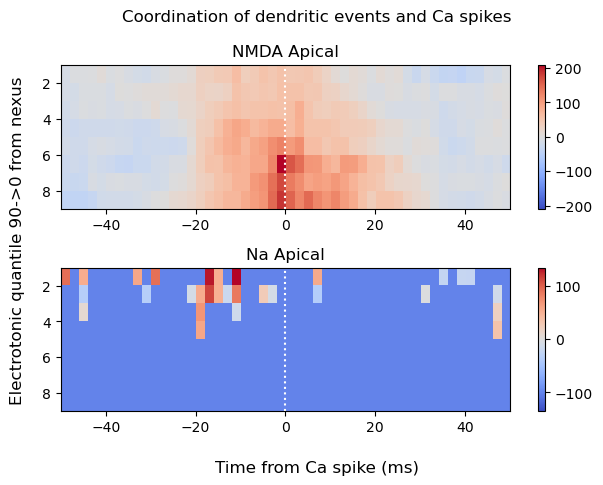

In [15]:
fig,ax = plt.subplots(2,1)
plot_sta_im(pois_ca_sta['nmda_a'], ax[0])
ax[0].set_title('NMDA Apical')
plot_sta_im(pois_ca_sta['na_a'], ax[1])
ax[1].set_title('Na Apical')

fig.supxlabel('Time from Ca spike (ms)')
fig.supylabel('Electrotonic quantile 90->0 from nexus')
fig.suptitle('Coordination of dendritic events and Ca spikes')
fig.tight_layout()
fig.savefig('../figures/DendSpikesCaCC.pdf')

#### Plot how Ca2+ spikes change the coordination between NMDA spikes and APs

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_caspks_csv.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  caspk_df = pd.read_csv(fpath)


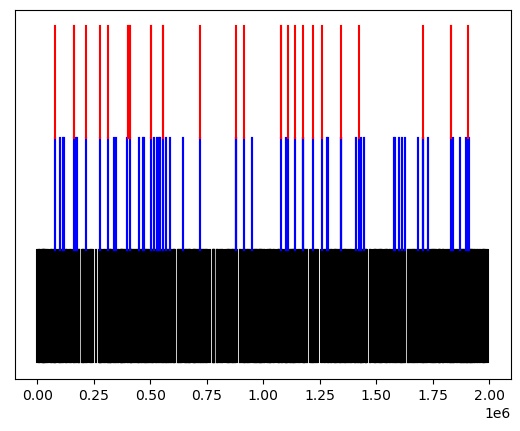

In [16]:
# get spkikes that are 20 ms after the start of a Ca spike
caspk_t = load_caspks_csv(sim_dict['CaFile'])
spk_t = load_spike_h5(sim_dict['APFile'])

lag_win = samps_per_ms * 20
spk_ca_t = [curr_spk for curr_spk in spk_t if np.any(((curr_spk-caspk_t)<lag_win)&((curr_spk-caspk_t)>=0))]


# create a method that makes a raster plot of spike times
def plot_raster(spk_t, ax, offset=0, **kwargs):
    for curr_spk in spk_t:
        ax.plot([curr_spk, curr_spk], np.array([0,1])+offset, **kwargs)
        
    ax.set_yticks([])

# plot the raster
fig,ax = plt.subplots()
plot_raster(spk_t, ax, 0, color='black')
plot_raster(caspk_t, ax, 1, color='blue')
plot_raster(spk_ca_t, ax, 2, color='red')

In [17]:
# process the simulation
pois_canmda_sta = {}
pois_canmda_sta['nmda_sta'] = sta_files(sim_dict['NMDAFile'], spk_ca_t, 
                                 step, sim_win,sta_step,sta_win, 
                                 agg_colname='Elec_distanceQ')
pois_canmda_sta['na_sta'] = sta_files(sim_dict['NaFile'], spk_ca_t, 
                                 step, sim_win,sta_step,sta_win, 
                                 agg_colname='Elec_distanceQ')

pois_canmda_sta['nmda_a'] = pois_canmda_sta['nmda_sta'].loc['apic','sta']
pois_canmda_sta['nmda_b'] = pois_canmda_sta['nmda_sta'].loc['dend','sta']
pois_canmda_sta['na_a'] = pois_canmda_sta['na_sta'].loc['apic','sta']
pois_canmda_sta['na_b'] = pois_canmda_sta['na_sta'].loc['dend','sta']


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Resul

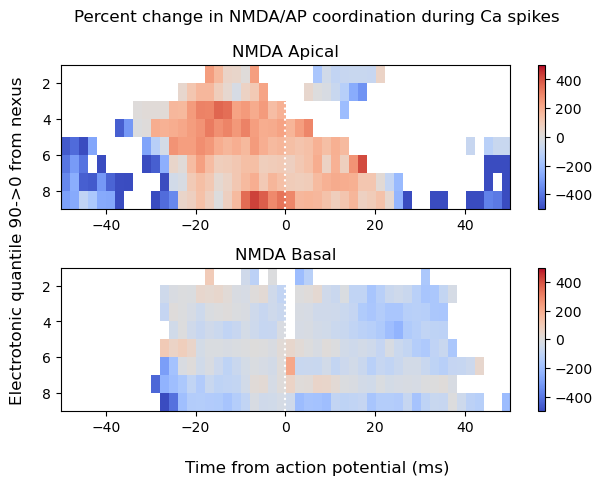

In [29]:
# numpy restrict values to set range
def prc_chg(chg_map,base_map):
    # set denom values less than 10 to nan
    
    #base_map[abs(base_map)<10] = np.nan
    #out_map = np.clip(chg_map/base_map,-5,5)
    out_map = np.clip((chg_map-base_map)/np.abs(base_map), -5, 5)*100

    
    return out_map

fig,ax = plt.subplots(2,1)
plot_sta_im(prc_chg(pois_canmda_sta['nmda_a'],pois_sta['nmda_a']), ax[0])
ax[0].set_title('NMDA Apical')
plot_sta_im(prc_chg(pois_canmda_sta['nmda_b'],pois_sta['nmda_b']), ax[1])
ax[1].set_title('NMDA Basal')
fig.supxlabel('Time from action potential (ms)')
fig.supylabel('Electrotonic quantile 90->0 from nexus')
fig.suptitle('Percent change in NMDA/AP coordination during Ca spikes')
fig.tight_layout()
fig.savefig('../figures/NMDAAPCC_modbyCa.pdf')